In [1]:
import re
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from openTSNE import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.metrics import auc
from openTSNE import TSNE

# from sklearn.manifold import TSNE
from openTSNE import TSNE
from gensim.models import Word2Vec
import networkx as nx 
from matplotlib.lines import Line2D
import pickle 
from itertools import combinations
%matplotlib inline

import gc 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap

import matplotlib.colors as mcolors

/home/felix/vscodeProjects/arxiv_nlp/arxiv_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-12 13:18:14.062645: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 13:18:14.087196: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 13:18:14.225497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 13:18:14.225548: E external/local_xla/xla/stream_executor/c

In [2]:

plt.style.use('tableau-colorblind10')
def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "serif",
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

# Compare Baseline

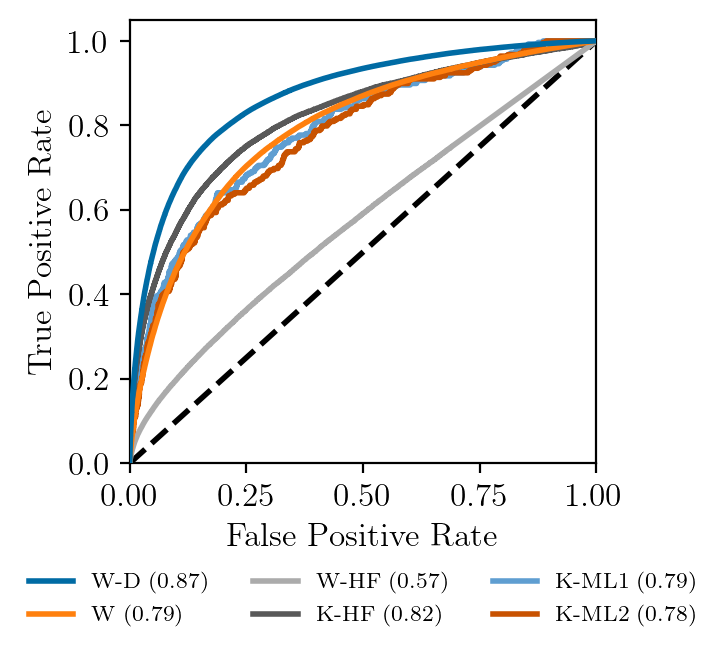

In [3]:
# Word Embedding (W) with time info 
# Word Embedding without time info 
# Word Embedding without time info and extracted feature 

# Knowledge Graph (K) with hand hand-crafted features (NF)
# Knowledge Graph (K) with pure ml (probe embedding)
# Knowledge Graph (K) with pure ml (node2vec embedding)

# our method W-T - Word Embedding with time info
fpr_method = np.load("saved_files/fpr_method_final.npy")
tpr_method = np.load("saved_files/tpr_method_final.npy")

# pred model based on cosine sim of concepts  
# W-NT+F - Word Embedding without time info + hand-crafted features
fpr_baseline_1 = np.load("saved_files/fpr_baseline_1.npy")
tpr_baseline_1 = np.load("saved_files/tpr_baseline_1.npy")

# method but static embedding 
# W-NT - Word Embedding without time info
fpr_baseline_2 = np.load("saved_files/fpr_baseline_2.npy")
tpr_baseline_2 = np.load("saved_files/tpr_baseline_2.npy")

# 15 hand crafted features 
# K+NF - Knowledge Graph with hand-crafted features
fpr_baseline_3 = np.load("saved_files/fpr_baseline_3.npy")
tpr_baseline_3 = np.load("saved_files/tpr_baseline_3.npy")


# prone
# K+PE - Knowledge Graph with pure ML (probe embedding)
fpr_baseline_4 = np.load("saved_files/fpr_baseline_4.npy")
tpr_baseline_4 = np.load("saved_files/tpr_baseline_4.npy")

# 1node2vec
# K+N2V - Knowledge Graph with pure ML (node2vec embedding)
fpr_baseline_5 = np.load("saved_files/fpr_baseline_5.npy")
tpr_baseline_5 = np.load("saved_files/tpr_baseline_5.npy")

from scipy.signal import savgol_filter



fig,axs = plt.subplots(figsize=(3.54331, 3.54331))
axs.plot(fpr_method, tpr_method, lw=2, label='W-D (%0.2f)' % auc(fpr_method, tpr_method),zorder=5)
axs.plot(fpr_baseline_2, tpr_baseline_2,  lw=2,  label='W  (%0.2f)' % auc(fpr_baseline_2, tpr_baseline_2),zorder=4)
axs.plot(fpr_baseline_1, tpr_baseline_1,  lw=2,  label='W-HF (%0.2f)' % auc(fpr_baseline_1, tpr_baseline_1),zorder=3)
axs.plot(fpr_baseline_3, tpr_baseline_3, lw=2, label='K-HF (%0.2f)' % auc(fpr_baseline_3, tpr_baseline_3),zorder=2)
axs.plot(fpr_baseline_4, tpr_baseline_4,  lw=2,  label='K-ML1 (%0.2f)' % auc(fpr_baseline_4, tpr_baseline_4),zorder=1)
axs.plot(fpr_baseline_5, tpr_baseline_5, lw=2, label='K-ML2 (%0.2f)' % auc(fpr_baseline_5, tpr_baseline_5),zorder=1)

axs.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=8, frameon=False)

plt.tight_layout()
fig.savefig("figures/roc.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)

    return result

def flatten_matrix(matrix):
    flat = []
    for r in matrix:
        # for c in r:
        flat += r
    return np.unique(flat)

def compute_word_count_subset(corpus, subset_words):
    
    for document in tqdm(corpus):
        for word in document:
            if word in subset_words:
                subset_words[word] += 1
    return subset_words

In [5]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

c_inx_arr = np.memmap("saved_files/embedding_concept_arr.dat",shape=(10235,), dtype="<U55")
c_encoding_arr = np.memmap("saved_files/embedding_vector_arr.dat",shape=(10235, 30, 128), dtype=np.float64)


In [6]:
# Compute word count for the subset of words 
word_count_subset = compute_word_count_subset([row.split() for row in ngram_abstracts], {k:0 for k in np.unique(c_inx_arr)})

def filter_dict_by_occurrence(word_count_dict, n):
    return {word: count for word, count in word_count_dict.items() if count > n}

filtered_concept_dict = np.array(list(filter_dict_by_occurrence(word_count_subset, 4).keys()))

ocurr_arr = {}
for abstract, year in tqdm(zip(ngram_abstracts, year_arr)):
    temp = keep_words_with_underscore(abstract)
    if year not in ocurr_arr:
        ocurr_arr[year] = []
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in filtered_concept_dict]
        l = [list(filter(("_").__ne__, temp))]
        ocurr_arr[year].extend(l)

new_ocurr_arr = {}
for year in tqdm(np.unique(year_arr)):
    new_ocurr_arr[year] = flatten_matrix(ocurr_arr[year])

100%|██████████| 66839/66839 [00:00<00:00, 249234.62it/s]
66839it [00:08, 8172.70it/s] 
100%|██████████| 30/30 [00:00<00:00, 174.61it/s]


In [7]:
occur_count_2012 = {k:0 for k in c_inx_arr}
for i in ocurr_arr[2012]:
    for j in i:
        occur_count_2012[j] += 1


occur_count_2022 = {k:0 for k in c_inx_arr}
for i in ocurr_arr[2022]:
    for j in i:
        occur_count_2022[j] += 1


In [8]:
def preprocess_connections(connections):
    all_pairs = set()  # Using a set to automatically avoid duplicates

    for group in connections:
        unique_words = list(set(group))  # Remove duplicates within each group
        # Generate all possible pairs (combinations of 2) from the unique words
        for pair in combinations(unique_words, 2):
            # Sort the pair to enforce permutation invariance
            sorted_pair = tuple(sorted(pair))
            all_pairs.add(sorted_pair)
    return list(all_pairs)

# Get the processed connections
processed_connections_2012 = preprocess_connections(ocurr_arr[2012])
processed_connections_2022 = preprocess_connections(ocurr_arr[2022])
# Output the unique pairs
print(len(processed_connections_2012))
print(len(processed_connections_2022))

28958
78787


In [9]:
# Dictionary to store the first occurrence year of each word
first_occurrences = {}

# Dictionary to count the number of first occurrences per year
new_words_per_year = {}

# Iterate through the years in sorted order
for year in sorted(new_ocurr_arr.keys()):
    new_words_count = 0
    for word in new_ocurr_arr[year]:
        if word not in first_occurrences:
            first_occurrences[word] = year
            new_words_count += 1
    new_words_per_year[year] = new_words_count

years = sorted(new_words_per_year.keys())
cumulative_sum = [sum(new_words_per_year[y] for y in years if y <= year) for year in years]

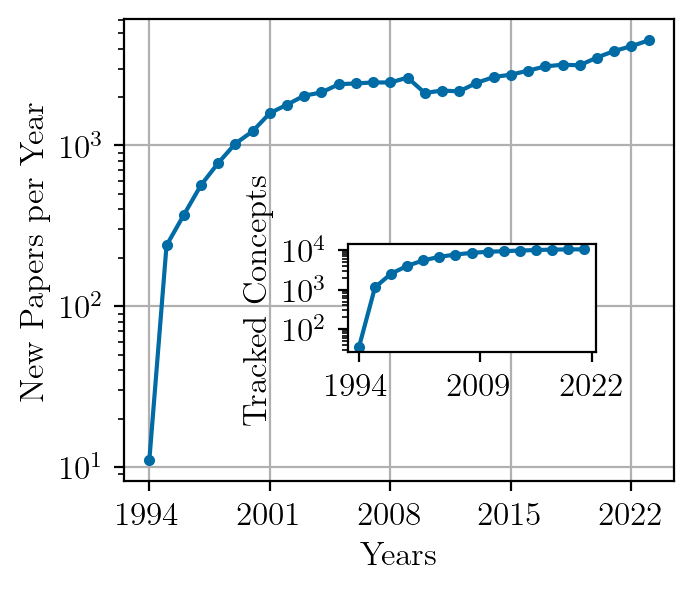

In [10]:
years, numpapers_y = np.unique(year_arr,return_counts=True)
fig, ax = plt.subplots(figsize=(3.54331, 3.0))

ax.plot( years, numpapers_y[:], '-o', markersize=3 )
ax.set_xticks(years[::7])
# ax.set_xticklabels( years[::4], rotation=45 )
ax.set_yscale("log")
ax.set_ylabel("New Papers per Year")
ax.grid(True)
ax.set_xlabel("Years")

ax2 = fig.add_axes([0.44, 0.25+0.075, 0.25+0.1, 0.18])
ax2.plot(np.arange(len(numpapers_y))[:-1][::2], cumulative_sum[:-1][::2], '-o', markersize=3)
# ax2.grid(True)
# ax2.set_xticks( list(range(len(years))[::7]))
# ax2.set_xticklabels( years[::7], rotation=45 )
ax2.set_xticks( [0,15,29])
ax2.set_xticklabels( [1994,2009,2022] )


ax2.set_yscale("log")
ax2.set_ylabel("Tracked Concepts")
# fig.tight_layout()
fig.savefig("figures/c_per_year.pdf", format="pdf", bbox_inches="tight")

# Plotting Def

In [11]:
def cluster_embeddings(vectors, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters,n_init="auto",random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    return clusters, kmeans.cluster_centers_

def reduce_dimensions(vectors, second_vectors=np.empty(0), method='UMAP'):
    if method == 'PCA':
        pca = PCA(n_components=2)
        if second_vectors.size == 0:
            return pca.fit_transform(vectors)
        else: 
            return pca.fit_transform(vectors), pca.transform(second_vectors)
        
    elif method == 't-SNE':
        tsne = TSNE(n_components=2,perplexity=30,learning_rate=200,random_state=42)
        if second_vectors.size == 0:
            return tsne.fit_transform(vectors)
        else: 
            return tsne.fit_transform(vectors), tsne.fit_transform(second_vectors)
    
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2,n_neighbors=15, min_dist=0.9)
        if second_vectors.size == 0:
            return reducer.fit_transform(vectors)
        else: 
            return reducer.fit_transform(vectors), reducer.transform(second_vectors)

def find_closest_point(coord, points):
    # Convert to NumPy arrays for vectorized operations
    coord = np.array(coord)
    points = np.array(points)
    
    # Compute Euclidean distances: ||point - coord||
    distances = np.linalg.norm(points - coord, axis=1)
    
    # Find the index of the minimum distance
    closest_index = np.argmin(distances)
    
    # Return the closest point
    return points[closest_index]

# Cluster First

In [12]:
model_w2v_2012 = Word2Vec.load("saved_w2v_models/re_model_year_{}.model".format(2012)) 
model_w2v_2022 = Word2Vec.load("saved_w2v_models/re_model_year_{}.model".format(2022)) 

encoding_arr_2012 = np.array([model_w2v_2012.wv.get_vector(w) for w in filtered_concept_dict if w in model_w2v_2012.wv])
encoding_arr_2022 = np.array([model_w2v_2022.wv.get_vector(w) for w in filtered_concept_dict if w in model_w2v_2022.wv])

red_arr_2012 = np.array([w for w in filtered_concept_dict if w in model_w2v_2012.wv])
red_arr_2022 = np.array([w for w in filtered_concept_dict if w in model_w2v_2022.wv])
gc.collect()


100

# Cluster

In [13]:
reduced_vectors_2012 = reduce_dimensions(encoding_arr_2012)
reduced_vectors_2022 = reduce_dimensions(encoding_arr_2022)

In [14]:
clusters_2012, centers_2012 = cluster_embeddings(reduced_vectors_2012,n_clusters=9)
clusters_2022, centers_2022 = cluster_embeddings(reduced_vectors_2022,n_clusters=9)

In [15]:
def plot_most_sim_2d_double(reduced_vectors_2012, words_2012, clusters_2012, connections_2012, word_count_2012, centers_2012, model_2012,
                            reduced_vectors_2022, words_2022, clusters_2022, connections_2022, word_count_2022, centers_2022, model_2022):
    # Create the figure and two subplots (side by side)
    fig, axes = plt.subplots(2, 2, figsize=(7, 3.5), )  # figsize for a double column plot

    # First plot for 2012 data
    conc_dict_2012 = plot_most_sim_2d_single(axes[0,0], reduced_vectors_2012, words_2012, clusters_2012, connections_2012, word_count_2012, centers_2012, model_2012,"Blues")
    
    # Second plot for 2022 data
    conc_dict_2022 = plot_most_sim_2d_single(axes[0,1], reduced_vectors_2022, words_2022, clusters_2022, connections_2022, word_count_2022, centers_2022, model_2022,"Oranges")

    axes[0,0].text(0.95+0.01, 0.05-0.01, '2012', transform=axes[0,0].transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='right', 
             bbox=dict(facecolor='white', alpha=0.0))

    # For the 2022 subplot
    axes[0,1].text(0.95+0.01, 0.05-0.01, '2022', transform=axes[0,1].transAxes, fontsize=8,
                verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(facecolor='white', alpha=0.0))
    
    add_cluster_boxes(axes[1,0], conc_dict_2012)
    add_cluster_boxes(axes[1,1], conc_dict_2022)
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # plt.savefig("/home/felix/Downloads/figure_cluster.pdf", format="pdf", bbox_inches="tight",dpi=200)
    plt.show()
    gc.collect()

def add_cluster_boxes(ax, wdict):
    cluster_labels = list(wdict.keys())
    word_lists = list(wdict.values())
    # Create textboxes for each cluster label and associated words
    for i, (cluster, words) in enumerate(zip(cluster_labels, word_lists)):
        # Position each text box
        ax.text(0.1, 1 - 0.1 * (i + 1), f'{cluster}: ' + ', '.join(words), 
                fontsize=10, ha='left', va='top', transform=ax.transAxes)

def plot_most_sim_2d_single(ax, reduced_vectors, words, clusters, connections, word_count, centers, model,cmap):
    
    unique_clusters = np.unique(clusters)
    if cmap == "Blues":
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Blues', plt.cm.Blues(np.linspace(0.2, 1, 256)))

    else: 
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Oranges', plt.cm.Oranges(np.linspace(0.2, 1, 256)))

    ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap=new_cmap, s=5, alpha=1, zorder=3)
    
    conc_dict = {}
    
    # Plot the convex hulls for each cluster
    for i, cluster in enumerate(unique_clusters):
        points = reduced_vectors[clusters == cluster]
        cluster_words = words[clusters == cluster]
        center_x, center_y = centers[i]
        top_30 = [cluster_words[np.where(points == find_closest_point(centers[i], points))[0][0]]]
        top_30.extend(np.array(model.wv.most_similar(positive=[top_30[0]], topn=20))[:, 0])
        top_ = [word for word in top_30 if word in words]
        
        print("C"+str(i))
        print(sorted(top_, key=lambda x: word_count[x], reverse=True))
        print("\n")
        top_5 = [word for word in top_30 if word in words][:3]
        conc_dict["C"+str(i)] = [word_.replace("_", " ").title() for word_ in top_5]
        text_str = "\n".join([word_.replace("_", " ").title() for word_ in top_5])
        text_str = "C"+str(i)
        x = center_x
        y = center_y 
        ax.text(x, y, text_str, color='black', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.95, edgecolor='none',boxstyle='round,pad=0.5'), zorder=3, horizontalalignment='center')

    ax.set_xticks([])
    ax.set_yticks([])
    return conc_dict 

In [19]:
def plot_most_sim_2d_single(ax, reduced_vectors, words, clusters,  word_count, centers, model,cmap, letter):
    
    unique_clusters = np.unique(clusters)
    if cmap == "Blues":
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Blues', plt.cm.Blues(np.linspace(0.2, 1, 256)))

    else: 
        new_cmap = mcolors.LinearSegmentedColormap.from_list('Oranges', plt.cm.Oranges(np.linspace(0.2, 1, 256)))

    ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap=new_cmap, s=5, alpha=1, zorder=3)
    
    # Plot the convex hulls for each cluster
    for i, cluster in enumerate(unique_clusters):
        points = reduced_vectors[clusters == cluster]
        cluster_words = words[clusters == cluster]
        center_x, center_y = centers[i]
        top_30 = [cluster_words[np.where(points == find_closest_point(centers[i], points))[0][0]]]
        top_30.extend(np.array(model.wv.most_similar(positive=[top_30[0]], topn=30))[:, 0])
        top_ = [word for word in top_30 if word in words]
        top_5 = sorted(top_, key=lambda x: word_count[x], reverse=True)
        

        text_str = "\n".join([word_.replace("_", " ").title() for word_ in top_5])
        text_str = letter+str(i)
        x = center_x
        y = center_y 
        ax.text(x, y, text_str, color='black', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.95, edgecolor='none',boxstyle='round,pad=0.5'), zorder=3, horizontalalignment='center')

    ax.set_xticks([])
    ax.set_yticks([])
   

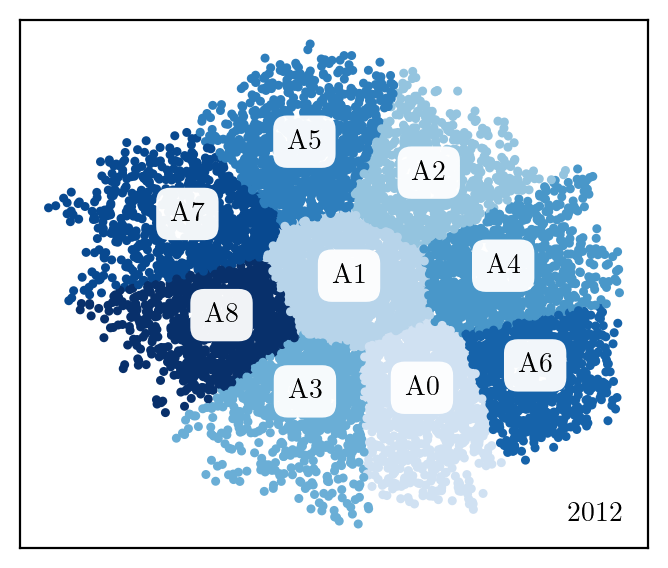

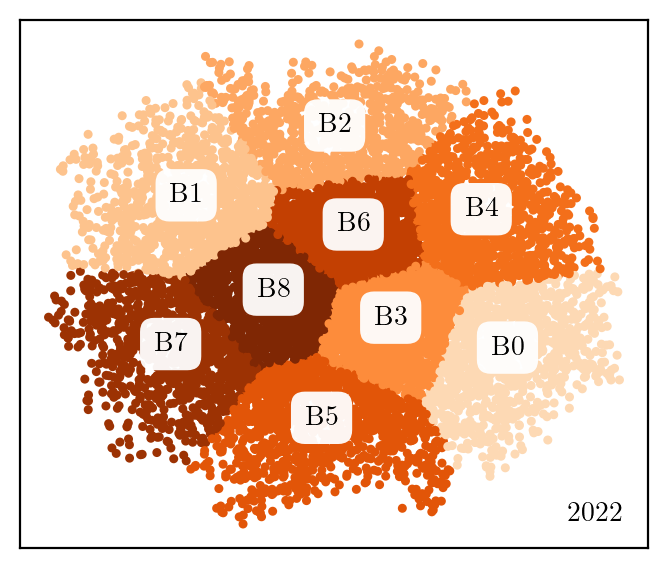

2884

In [20]:

fig, axes = plt.subplots( figsize=(3.5, 3))  

# First plot for 2012 data
plot_most_sim_2d_single(axes, reduced_vectors_2012, red_arr_2012, clusters_2012,  occur_count_2012, centers_2012, model_w2v_2012,"Blues","A")

axes.text(0.95+0.01, 0.05-0.01, '2012', transform=axes.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(facecolor='white', alpha=0.0))

plt.tight_layout()
plt.savefig("figures/cluster2012.pdf", format="pdf", bbox_inches="tight")
plt.show()
gc.collect()


fig, axes = plt.subplots( figsize=(3.5, 3))
plot_most_sim_2d_single(axes, reduced_vectors_2022, red_arr_2022, clusters_2022,  occur_count_2022, centers_2022, model_w2v_2022,"Oranges","B")


axes.text(0.95+0.01, 0.05-0.01, '2022', transform=axes.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(facecolor='white', alpha=0.0))

plt.tight_layout()
plt.savefig("figures/cluster2022.pdf", format="pdf", bbox_inches="tight")
plt.show()
gc.collect()
    


UMAP hyp test

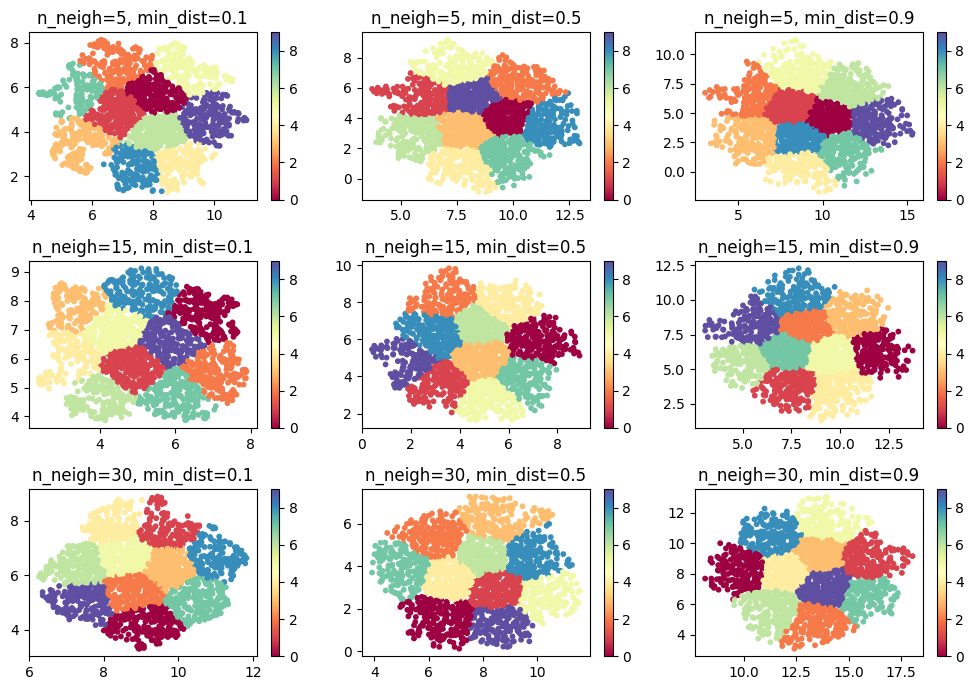

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Create a 3x3 grid
axes = axes.flatten()  # Flatten the axes for easy iteration

# Initialize a counter for subplots
subplot_index = 0

# Iterate through different perplexity and learning_rate combinations
for n_neighbors in [5, 15, 30]:
    for min_dist in [0.1, 0.5, 0.9]:
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        X_umap = umap_model.fit_transform(encoding_arr_2022[::5])
        
        
        # Assuming `cluster_embeddings` is your function to get cluster labels
        reduced_vectors,_ = cluster_embeddings(X_umap, n_clusters=10)
        
        # Plot the clusters in the corresponding subplot
        scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=reduced_vectors, cmap='Spectral', s=10)
        axes[subplot_index].set_title(f"n_neigh={n_neighbors}, min_dist={min_dist}")
        plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
        subplot_index += 1  # Move to the next subplot index

# Adjust plot layout and show
plt.tight_layout()
plt.show()

# kmeans hyp

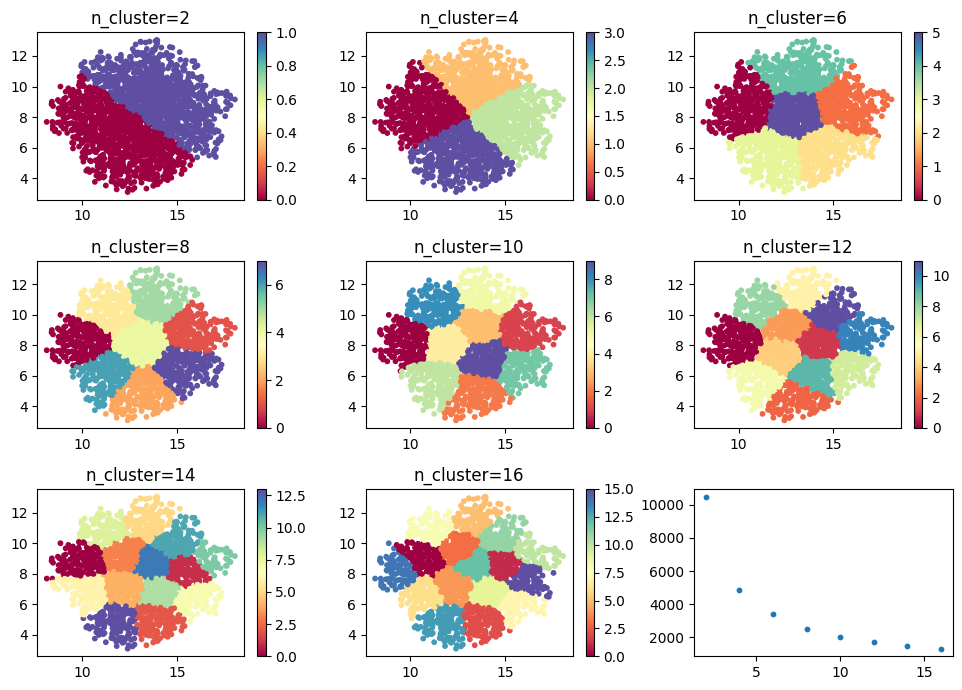

In [ ]:
# List of clustering models to loop over
models = [('KMeans', KMeans(n_clusters=n, random_state=42,n_init="auto")) for n in np.arange(2,2*9,2)]

# Set up the plot
fig, axes = plt.subplots(3, 3, figsize=(10, 7))  # Adjust rows/columns based on the number of models
axes = axes.flatten()

inertia_arr = []
subplot_index = 0
# Loop through models, fit, and plot
for i, (name, model) in enumerate(models):
    # Fit the model
    model.fit(X_umap)
    labels = model.predict(X_umap)

    scatter = axes[subplot_index].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
    axes[subplot_index].set_title(f"n_cluster={np.arange(2,2*9,2)[i]}")
    plt.colorbar(scatter, ax=axes[subplot_index])  # Add colorbar
    subplot_index += 1  # Move to the next subplot index

    inertia_arr.append(model.inertia_)

axes[subplot_index].scatter(np.arange(2,2*9,2), inertia_arr, s=10)
plt.tight_layout()
plt.show()

# Most connected concepts

In [ ]:
# Print the edge list to verify
with open('saved_files/graph_edges.pkl', 'rb') as f:
    edge_list = pickle.load(f)
    print(edge_list[0])


graph = nx.Graph()
graph.add_weighted_edges_from(edge_list)

[0, 1, 11323]


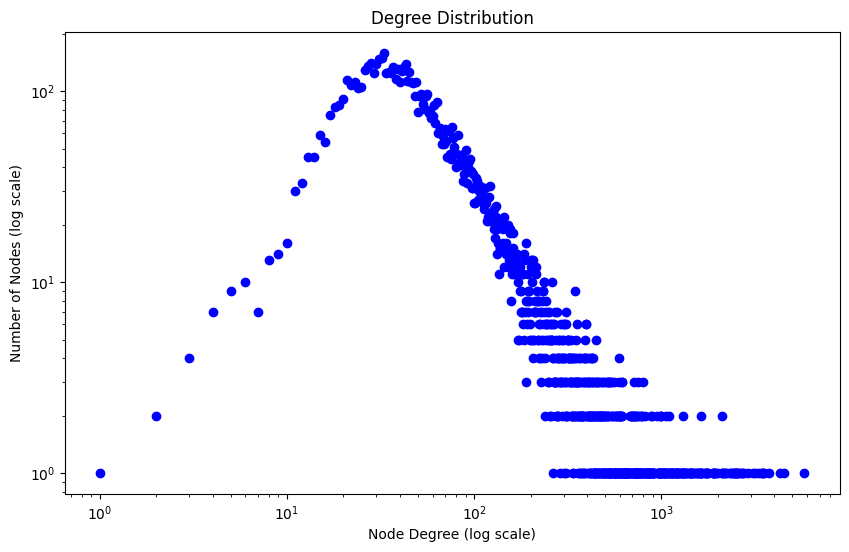

In [ ]:
# Step 2: Compute the degree of each node
from collections import Counter

degree_sequence = [d for n, d in graph.degree()]

# Step 3: Calculate the degree distribution
degree_count = Counter(degree_sequence)
degree, count = zip(*degree_count.items())

# Step 4: Plot the distribution with log scales on both axes
plt.figure(figsize=(10, 6))
plt.scatter(degree, count, c='blue')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Node Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Degree Distribution')

# plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
# Find the top 20 nodes with the lowest and highest degrees
sorted_nodes_by_degree = sorted(graph.degree(), key=lambda x: x[1])

# Top 20 nodes with the lowest degrees
top_20_lowest_degree_nodes = sorted_nodes_by_degree[:10]

# Top 20 nodes with the highest degrees
top_20_highest_degree_nodes = sorted_nodes_by_degree[-200:][::-1]

print("Highest Degree")
for c,cnt in top_20_highest_degree_nodes:
    
    print(c_inx_arr[c], cnt)

print("Lowest Degree")
for c,cnt in top_20_lowest_degree_nodes:
    print(c_inx_arr[c], cnt)



# Step 3: Calculate the degree distribution
degree_count = Counter(degree_sequence)
degree, count = zip(*degree_count.items())

Highest Degree
adiabatic_quantum_evolution 5802
auto_correlation 4538
atomic_collective_excitation 4294
abstract_model 3740
abelian_subgroup 3546
ab_initio 3475
atomic_beam 3459
arithmetic_operation 3411
belief_propagation_decoding 3300
angular_momentum_theory 3181
absorbing_boundary_condition 3069
adiabatic_transport 2895
atomic_thermal_motion 2776
chromatic_dispersion 2704
adiabatic_method 2680
average_photon_number 2658
artificial_intelligence 2599
achievable_efficiency 2551
antiferromagnetic_chain 2534
asymptotic_convergence 2512
bistable_behavior 2505
coherence_transfer 2502
analytic_representation 2469
base_field 2437
classification_performance 2400
breit_wigner 2370
bessel_beam 2365
analytical_solution 2311
carbon_nanotube 2238
amplitude_estimation_algorithm 2187
bacon_shor_code 2180
blind_quantum_computing 2140
adjacency_matrix 2105
action_integral 2105
basis_set 2103
action_angle 2095
biological_molecule 1997
adiabatic_preparation 1964
combinatorial_optimization 1927
adiabatic

In [ ]:
def similarity_cosine(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def cosine_distance(v1, v2):
    return 1-similarity_cosine(v1, v2)

word_list = ["entangled_state",
             "magnetic_field",
             "ground_state",
             "quantum_correlation",
             "phase_transition",
             "bell_inequality",
             "non_trivial", 
             "ab_initio", 
             "thermalization"
             ]

word_list = ["artificial_intelligence",
"adiabatic_preparation",
"carbon_nanotube",
"combinatorial_optimization",
"laser_light",
"adversarial_attack",
"coherence_measurement",
"cauchy_schwarz_inequality",
"adiabatic_quantum_evolution",
"bayesian_filter",
"bipartite_quantum_system",
"auto_correlation",
"adiabatic_method",
"antiferromagnetic_chain",
"analytic_representation",
"classification_performance",
]


# Initialize lists to track the top 20 increases and decreases
top_increase_total_concepts = [[] for _ in range(len(word_list))]
top_decrease_total_concepts = [[] for _ in range(len(word_list))]
top_increase_relative_concepts = [[] for _ in range(len(word_list))]
top_decrease_relative_concepts = [[] for _ in range(len(word_list))]

for cnt, c_1 in tqdm(enumerate(word_list)):
    print("Currently:", c_1)
    _inx_1 = np.where(c_inx_arr == c_1)[0]
    for _inx_2, c_2 in enumerate(c_inx_arr):
        _inx_2 = np.array([_inx_2])
        
        encoding1 = c_encoding_arr[_inx_1][0]
        encoding2 = c_encoding_arr[_inx_2][0]
        
        # Compute cosine similarities for each year
        similarity_per_year = [cosine_distance(v1, v2) for (v1, v2) in zip(encoding1, encoding2)]

        # distance_change = similarity_per_year[-1] - similarity_per_year[len(similarity_per_year)//2] 
        distance_change = np.max(similarity_per_year) - np.min(similarity_per_year)
        
        relative_change = distance_change / similarity_per_year[0] if similarity_per_year[0] != 0 else 0  # Avoid division by zero

        # Update top increase/decrease concepts if applicable
        if len(top_increase_total_concepts[cnt]) < 30:
            top_increase_total_concepts[cnt].append((c_1, c_2, distance_change))
            top_decrease_total_concepts[cnt].append((c_1, c_2, distance_change))
            top_increase_relative_concepts[cnt].append((c_1, c_2, relative_change))
            top_decrease_relative_concepts[cnt].append((c_1, c_2, relative_change))
        else:
            top_increase_total_concepts[cnt].sort(key=lambda x: x[2], reverse=True)
            top_decrease_total_concepts[cnt].sort(key=lambda x: x[2])
            top_increase_relative_concepts[cnt].sort(key=lambda x: x[2], reverse=True)
            top_decrease_relative_concepts[cnt].sort(key=lambda x: x[2])
            
            if distance_change > top_increase_total_concepts[cnt][-1][2]:
                top_increase_total_concepts[cnt][-1] = (c_1, c_2, distance_change)
            if distance_change < top_decrease_total_concepts[cnt][-1][2]:
                top_decrease_total_concepts[cnt][-1] = (c_1, c_2, distance_change)
            if relative_change > top_increase_relative_concepts[cnt][-1][2]:
                top_increase_relative_concepts[cnt][-1] = (c_1, c_2, relative_change)
            if relative_change < top_decrease_relative_concepts[cnt][-1][2]:
                top_decrease_relative_concepts[cnt][-1] = (c_1, c_2, relative_change)

# After the loop, ensure the final top 20 lists are sorted correctly
for i in range(len(word_list)):
    top_increase_total_concepts[i] = sorted(top_increase_total_concepts[i], key=lambda x: x[2], reverse=True)[:20]
    top_decrease_total_concepts[i] = sorted(top_decrease_total_concepts[i], key=lambda x: x[2])[:20]
    top_increase_relative_concepts[i] = sorted(top_increase_relative_concepts[i], key=lambda x: x[2], reverse=True)[:20]
    top_decrease_relative_concepts[i] = sorted(top_decrease_relative_concepts[i], key=lambda x: x[2])[:20]

# Now `top_increase_total_concepts`, `top_decrease_total_concepts`, `top_increase_relative_concepts`, and `top_decrease_relative_concepts`
# will contain the top 20 increases and decreases for each concept pair.

0it [00:00, ?it/s]

Currently: artificial_intelligence


1it [00:01,  1.78s/it]

Currently: adiabatic_preparation


2it [00:03,  1.66s/it]

Currently: carbon_nanotube


3it [00:05,  1.71s/it]

Currently: combinatorial_optimization


4it [00:06,  1.68s/it]

Currently: laser_light


5it [00:08,  1.70s/it]

Currently: adversarial_attack


6it [00:10,  1.64s/it]

Currently: coherence_measurement


7it [00:11,  1.64s/it]

Currently: cauchy_schwarz_inequality


8it [00:13,  1.61s/it]

Currently: adiabatic_quantum_evolution


9it [00:14,  1.59s/it]

Currently: bayesian_filter


10it [00:16,  1.56s/it]

Currently: bipartite_quantum_system


11it [00:17,  1.53s/it]

Currently: auto_correlation


12it [00:19,  1.54s/it]

Currently: adiabatic_method


13it [00:20,  1.53s/it]

Currently: antiferromagnetic_chain


14it [00:22,  1.54s/it]

Currently: analytic_representation


15it [00:23,  1.57s/it]

Currently: classification_performance


16it [00:25,  1.60s/it]


In [ ]:
# Print top 10 concepts with the largest increase and decrease in distance
print("Top 10 concepts with the largest total increase in distance:")
for con in top_increase_total_concepts:
    for concept in con:
        print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")

print("\nTop 10 concepts with the largest total decrease in distance:")
for con in top_decrease_total_concepts:
    for concept in con:
        print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")
# Print top 10 concepts with the largest increase and decrease in distance
print("Top 10 concepts with the largest relative increase in distance:")

for con in top_increase_relative_concepts:
    for concept in con:
        print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")

print("\nTop 10 concepts with the largest relative decrease in distance:")
for con in top_decrease_relative_concepts:
    for concept in con:
        print(f"Concept pair: {concept[0]}, {concept[1]}, Distance change: {concept[2]:.2f}")

Top 10 concepts with the largest total increase in distance:
Concept pair: artificial_intelligence, np_problem, Distance change: 1.43
Concept pair: artificial_intelligence, xor_gate, Distance change: 1.41
Concept pair: artificial_intelligence, extended_hilbert_space, Distance change: 1.35
Concept pair: artificial_intelligence, quantum_robot, Distance change: 1.35
Concept pair: artificial_intelligence, n_dimensional_space, Distance change: 1.32
Concept pair: artificial_intelligence, spin_coherent_state, Distance change: 1.31
Concept pair: artificial_intelligence, shannon_information, Distance change: 1.29
Concept pair: artificial_intelligence, boolean_logic, Distance change: 1.27
Concept pair: artificial_intelligence, halting_problem, Distance change: 1.27
Concept pair: artificial_intelligence, tensor_power, Distance change: 1.25
Concept pair: artificial_intelligence, dirac_particle, Distance change: 1.25
Concept pair: artificial_intelligence, square_integrable_function, Distance change

In [ ]:
data_dict = {
    "entangled_state":{"bell_measurement":{},"tripartite_quantum_state":{},"resonance_interaction":{},"positive_lyapunov_exponent":{},"liouville_equation":{},"noether_theorem":{}},
    "magnetic_field":{"drift_velocity":{},"conserved_quantity":{},"spin_coupling":{},"jacobi_matrix":{},"schroedinger_operator":{},"toffoli_gate":{}},
    "ground_state":{"excitation_gap":{},"slater_determinant":{},"matrix_product_state_representation":{},"deformation_quantization":{},"reversible_computing":{},"logic_gate":{}},
    "quantum_correlation":{"gaussian_quantum_discord":{},"jaynes_principle":{},"quantum_indistinguishability":{},"variational_principle":{},"superconducting_circuit":{},"differential_equation":{}},
    "phase_transition":{"quantum_defect":{},"quantum_defect":{},"quantum_zeno_effect":{},"modular_exponentiation":{},"group_transformation":{},"ladder_operator":{}},
    "bell_inequality":{"maximal_quantum_violation":{},"multiple_system":{},"quantum_non_locality":{},"heterodyne_detection_scheme":{},"mode_squeezing":{},"phase_space":{}},
}

for concept_1, dict_1 in data_dict.items():
    selw_inx = np.where(c_inx_arr==concept_1)[0]
    for concept_2, dict_2 in dict_1.items():
        
        selc_inx = np.where(c_inx_arr==concept_2)[0]

        try:
            data_dict[concept_1][concept_2] = {year:cosine_distance(c_encoding_arr[selw_inx][0][i],c_encoding_arr[selc_inx][0][i]) for i,year in enumerate(np.unique(year_arr))}
        except:
            print(concept_1,concept_2,"fails")
            

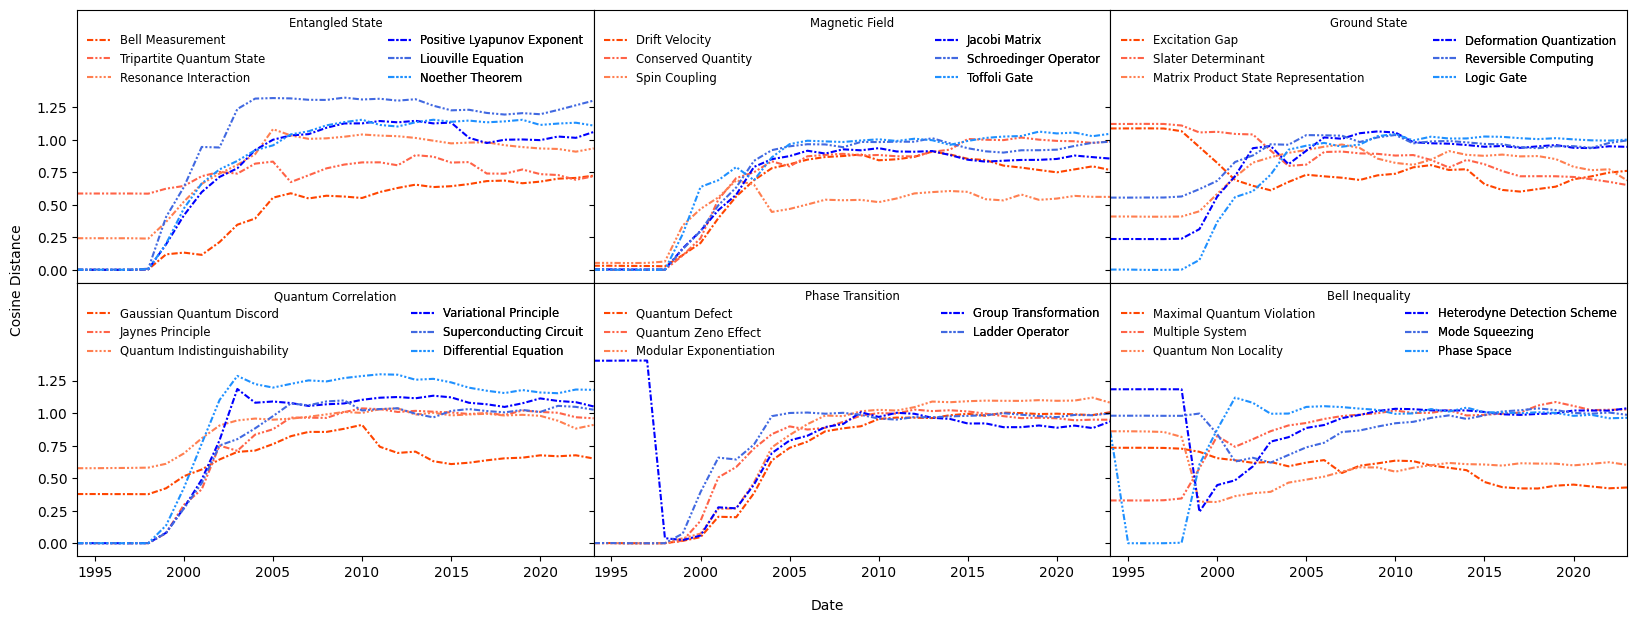

In [ ]:
# Define colors
red_hues = ['#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FFA07A']
blue_hues = ['#0000FF', '#4169E1', '#1E90FF', '#00BFFF', '#87CEFA']

linestyles = [
    (0, (3, 1, 1, 1)),         # dash dot dash
    (0, (3, 1, 1, 1, 1, 1)),   # dash dot dot dash
    (0, (3, 1, 1, 1, 1, 1, 1, 1)), # dash dot dot dot dash
    (0, (3, 1, 1, 1, 1, 1, 1, 1, 1, 1)), # dash dot dot dot dot dash
    (0, (3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))  # dash dot dot dot dot dot dash
]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 7.1), sharex=True, sharey=True)
axes = axes.flatten()

main_words = list(data_dict.keys())
years = sorted(list(data_dict[main_words[0]][list(data_dict[main_words[0]].keys())[0]].keys()))

for i, main_word in enumerate(main_words):
    ax = axes[i]
    red_lines = []
    blue_lines = []
    for j, (related_word, distances) in enumerate(data_dict[main_word].items()):
        distances_over_time = [distances[year] for year in years]
        color = red_hues[j % 3] if j < 3 else blue_hues[j % 3]
        linestyle = linestyles[j % 3] 
        
        label = related_word
        line, = ax.plot(years, distances_over_time, color=color, linestyle=linestyle, label=label)
        
        if j < 3:
            red_lines.append(line)
        else:
            blue_lines.append(line)
    
    ax.text(0.5, 0.975, main_word.replace("_"," ").title(), horizontalalignment='center', verticalalignment='top', transform=ax.transAxes, fontsize="small")#, bbox=dict(facecolor='lightblue', alpha=0.5))
    ax.set_ylim(0, 1)
    ax.set_xlim(min(years), max(years))
    
    red_legend_handles = [Line2D([0], [0], color=red_hues[j % 3], linestyle=linestyles[j % 3], label=related_word.replace("_"," ").title() )
                          for j, related_word in enumerate(data_dict[main_word].keys()) if j < 3]

    blue_legend_handles = [Line2D([0], [0], color=blue_hues[j % 3], linestyle=linestyles[j % 3], label=related_word.replace("_"," ").title())
                           for j, related_word in enumerate(data_dict[main_word].keys()) if j >= 3]
    
    red_legend = ax.legend(handles=red_legend_handles, loc='upper left', fontsize='small',frameon=False,bbox_to_anchor=(0, 0.95))
    blue_legend = ax.legend(handles=blue_legend_handles, loc='upper right', fontsize='small',frameon=False, bbox_to_anchor=(1, 0.95))
    ax.add_artist(red_legend)
    ax.add_artist(blue_legend)
    ax.set_ylim([-0.1,2])
    ax.set_yticks([0,0.25,0.50,0.75,1,1.25])
    
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.095, 0.5, 'Cosine Distance', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()